In [1]:
from theFuncs import *

# DATA

In [2]:
# load_DTB3_SPY().to_csv('./data/spy_dtb3.csv')

In [3]:
sp100 = os.listdir(os.getcwd()+'/data/stock_dfs')
sp100_tickers = []
for csvfile in sp100:
    sp100_tickers.append(csvfile[:-4])

# sp100_tickers

In [4]:
ticker_data = get_ticker_data_multisource(
    sp100_tickers, 
    start="2019-01-02", 
    end="2021-11-01"
)
#start=2019-01-02
#end=2021-11-01

In [5]:
# nyse_tickers_cap = pd.read_csv("data/tickers_nyse.csv", index_col=0).MarketCap.dropna().apply(
#     lambda x: float(x[1: -1]) * 1e6 if x[-1] == "M" else float(x[1: -1]) * 1e6
# ).sort_values(ascending=False)[:200]

# nyse_tickers = nyse_tickers_cap.index

In [6]:
# nyse_ticker_weights = nyse_tickers_cap / nyse_tickers_cap.sum()
# nyse_ticker_weights.head()

In [7]:
# ticker_data = get_ticker_data_multisource(nyse_tickers)

In [8]:
tickers = sp100_tickers

model = RollingOLS.from_formula(
        "(ret - DTB3) ~ (spy_ret - DTB3)", 
        data = ticker_data.loc[tickers[0]], 
        window = 66
    ).fit(params_only=True)
df = model.params
df.columns = ["alpha", "Beta"]
df['ticker'] = tickers[0]
df.set_index('ticker', inplace=True, append=True)
df = df.reorder_levels(['ticker', 'date']).sort_index()


for ticker in tickers[1:]:
    try:
        model = RollingOLS.from_formula(
            "(ret - DTB3) ~ (spy_ret - DTB3)", 
            data = ticker_data.loc[ticker], 
            window = 66
        ).fit(params_only=True)

        temp = model.params
        temp.columns = ["alpha", "Beta"]
        temp['ticker'] = ticker
        temp.set_index('ticker', inplace=True, append=True)
        temp = temp.reorder_levels(['ticker', 'date']).sort_index()
        df = pd.concat(
            [ 
                df, 
                temp
            ]
        )
    except:
        continue

ticker_data = ticker_data.join(df)

ticker_data.head()

high        low       open      close       volume  \
ticker date                                                                  
AAPL   2019-01-03  36.430000  35.500000  35.994999  35.547501  365248800.0   
       2019-01-04  37.137501  35.950001  36.132500  37.064999  234428400.0   
       2019-01-07  37.207500  36.474998  37.174999  36.982498  219111200.0   
       2019-01-08  37.955002  37.130001  37.389999  37.687500  164101200.0   
       2019-01-09  38.632500  37.407501  37.822498  38.327499  180396400.0   

                        ret   spy_close    DTB3   spy_ret  alpha  Beta  
ticker date                                                             
AAPL   2019-01-03 -0.099607  232.998627  0.0236 -0.023863    NaN   NaN  
       2019-01-04  0.042689  240.803085  0.0237  0.033496    NaN   NaN  
       2019-01-07 -0.002226  242.701736  0.0241  0.007885    NaN   NaN  
       2019-01-08  0.019063  244.981995  0.0241  0.009395    NaN   NaN  
       2019-01-09  0.016982  246.126907  0.0240  0.004673    NaN   NaN

In [9]:
market_caps = pd.DataFrame(
    ticker_data.close * ticker_data.volume,
    columns=["MarketCap"]
)
market_caps.head()

MarketCap
ticker date                    
AAPL   2019-01-03  1.298368e+10
       2019-01-04  8.689088e+09
       2019-01-07  8.103280e+09
       2019-01-08  6.184564e+09
       2019-01-09  6.914143e+09

In [10]:
market_caps = market_caps.ewm(66).mean()

In [11]:
market_caps.head()

MarketCap
ticker date                    
AAPL   2019-01-03  1.298368e+10
       2019-01-04  1.082024e+10
       2019-01-07  9.900934e+09
       2019-01-08  8.950780e+09
       2019-01-09  8.531111e+09

In [12]:
ticker_data_wide = ticker_data.reset_index(level=['ticker', 'date'])
ticker_data_wide = ticker_data_wide[['ticker', 'date', 'ret']].pivot(
    index='date', 
    columns='ticker', 
    values='ret'
)
ticker_data_wide.head()

ticker,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMGN,AMT,AMZN,AVGO,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2019-01-03,-0.099607,-0.032949,-0.047194,-0.034142,-0.039498,-0.021959,-0.015216,0.005997,-0.025242,-0.088951,...,-0.027270,-0.037016,-0.028392,-0.014024,-0.036037,0.003570,-0.010435,-0.007882,-0.005142,-0.015354
2019-01-04,0.042689,0.032217,0.028541,0.038884,0.048632,0.036903,0.034184,0.003995,0.050064,0.009828,...,0.011695,0.038514,0.034833,0.024726,0.043081,0.002490,0.033269,0.029633,0.006246,0.036870
2019-01-07,-0.002226,0.014595,0.014976,0.003473,0.013573,0.005724,0.013457,0.006190,0.034353,0.020366,...,0.001920,0.006241,-0.003376,-0.004698,0.018032,0.006388,0.005750,-0.006465,0.011772,0.005200
2019-01-08,0.019063,0.004648,-0.012006,0.025290,0.014918,0.003959,0.012824,0.011300,0.016612,-0.008026,...,0.013371,0.087270,0.000103,0.006436,0.005439,0.029267,0.020009,-0.002099,0.006981,0.007271
2019-01-09,0.016982,-0.032823,0.016691,0.005030,0.011819,0.014543,-0.001196,-0.008753,0.001714,0.043250,...,0.001439,-0.002587,0.005132,0.010659,0.011769,-0.022782,0.012050,0.005469,-0.003256,0.005275


In [13]:
rolling_correlations = ticker_data_wide.rolling(66).corr().fillna(0)
rolling_correlations.head()

ticker             AAPL  ABBV  ABT  ACN  ADBE  AIG  AMGN  AMT  AMZN  AVGO  \
date       ticker                                                           
2019-01-03 AAPL     0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ABBV     0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ABT      0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ACN      0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ADBE     0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   

ticker             ...  UNH  UNP  UPS  USB    V   VZ  WBA  WFC  WMT  XOM  
date       ticker  ...                                                    
2019-01-03 AAPL    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ABBV    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ABT     ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ACN     ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ADBE    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 101 columns]

In [14]:
filter_correlations = rolling_correlations.groupby(["date"]).sum().sum(axis=1)
filter_correlations_dates = filter_correlations[filter_correlations > 0].index
rolling_correlations = rolling_correlations.loc[filter_correlations_dates]

In [15]:
rolling_covariances = ticker_data_wide.rolling(66).cov().fillna(0)
rolling_covariances.head()

ticker             AAPL  ABBV  ABT  ACN  ADBE  AIG  AMGN  AMT  AMZN  AVGO  \
date       ticker                                                           
2019-01-03 AAPL     0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ABBV     0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ABT      0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ACN      0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ADBE     0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   

ticker             ...  UNH  UNP  UPS  USB    V   VZ  WBA  WFC  WMT  XOM  
date       ticker  ...                                                    
2019-01-03 AAPL    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ABBV    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ABT     ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ACN     ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ADBE    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 101 columns]

In [16]:
filter_covariances = rolling_covariances.groupby(["date"]).sum().sum(axis=1)
filter_covariances_dates = filter_covariances[filter_covariances > 0].index
rolling_covariances = rolling_covariances.loc[filter_covariances_dates]

In [17]:
rolling_covariances.loc[('2019-06-24', 'AAPL'), 'AAPL']

date        ticker
2019-06-24  AAPL      0.000275
Name: AAPL, dtype: float64

In [18]:
# ticker_data.to_csv("data/test_run/ticker_data.csv")
# ticker_data_wide.to_csv("data/test_run/ticker_data_wide.csv")
# rolling_correlations.to_csv("data/test_run/rolling_correlations.csv")
# rolling_covariances.to_csv("data/test_run/rolling_covariances.csv")
# market_caps.to_csv("data/test_run/market_caps.csv")

In [19]:
# ticker_data = pd.read_csv("data/test_run/ticker_data.csv", index_col=[0, 1], parse_dates=True)
# ticker_data_wide = pd.read_csv("data/test_run/ticker_data_wide.csv", index_col=0, parse_dates=True)
# rolling_correlations = pd.read_csv("data/test_run/rolling_correlations.csv", index_col=[0, 1], parse_dates=True)
# rolling_covariances = pd.read_csv("data/test_run/rolling_covariances.csv", index_col=[0, 1], parse_dates=True)
# market_caps = pd.read_csv("data/test_run/market_caps.csv", index_col=[0, 1], parse_dates=True)

# CLUSTERING

In [20]:
date = get_closest_trading_day("2006-03-23", rolling_correlations)
K = 10

In [21]:
x, y, z = clustering_model(rolling_correlations, date, K, GRB.MAXIMIZE)

Academic license - for non-commercial use only - expires 2022-08-27
Using license file /Users/karimlayoun/gurobi.lic
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 10303 rows, 10302 columns and 30704 nonzeros
Model fingerprint: 0xd0b9d741
Variable types: 0 continuous, 10302 integer (10302 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 30.2952012
Presolve time: 0.05s
Presolved: 10303 rows, 10302 columns, 30704 nonzeros
Variable types: 0 continuous, 10302 integer (10302 binary)

Root relaxation: objective 6.457578e+01, 679 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     

# INDEX BY CLUSTER WEIGHTS

In [22]:
z_market_cap = market_caps.loc[
    market_caps.index.get_level_values(1) == date
].join(z)
z_market_cap.reset_index(drop=True, level=1, inplace=True)

In [23]:
center_weights = z_market_cap[(z_market_cap.in_center == 1) & (z_market_cap.is_center == 1)].groupby("center").MarketCap.sum() / z_market_cap[(z_market_cap.in_center == 1) & (z_market_cap.is_center == 1)].MarketCap.sum()

In [24]:
portfolio_returns = get_portfolio_returns(
    center_weights, date, ticker_data_wide
)
spy_returns = get_spy_returns(date)

portfolio_returns, spy_returns

(1.0656229126344496, 1.0335923745882458)

In [25]:
portfolio_returns - spy_returns

0.032030538046203816

In [26]:
get_portfolio_beta(center_weights, date, ticker_data)

1.0479391434505618

In [27]:
# master_func("2020-03-23", K, rolling_correlations, market_caps, ticker_data, ticker_data_wide, rolling_covariances, 0.5, 1.5, 1e-3)

# INDEX BY MIN VAR

In [28]:
mean_var_step, obj = mean_variance_model(
    market_caps, 
    ticker_data, 
    date, 
    rolling_covariances, 
    center_weights,
    0.5, 
    1.5, 
    1e-3
)

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 95 rows, 101 columns and 492 nonzeros
Model fingerprint: 0xa21f67d4
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e-05, 3e+00]
  Objective range  [6e-06, 4e-04]
  QObjective range [1e-07, 3e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 92 rows and 91 columns
Presolve time: 0.00s
Presolved: 3 rows, 11 columns, 31 nonzeros
Presolved model has 55 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 9
 AA' NZ     : 6.600e+01
 Factor NZ  : 7.800e+01
 Factor Ops : 6.500e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.81429787e+05 -1.81509324e+05  8.08e+03 2.29e-03  3.57e+05     0s
   1   7.

In [29]:
obj

0.004300320864851065

In [30]:
mean_var_step_return = get_portfolio_returns(mean_var_step.weights, date, ticker_data_wide)
mean_var_step_return, spy_returns

(1.0712322384909718, 1.0335923745882458)

In [31]:
mean_var_step_return - spy_returns

0.037639863902726

In [32]:
get_portfolio_beta(mean_var_step.weights, date, ticker_data)

0.828576708709377

# Method Comparison

In [33]:
pd.concat(
    [
        mean_var_step[mean_var_step.weights > 0], 
        center_weights
    ], 
    axis=1
)

,weights,MarketCap
CVS,4.080747e-08,0.036136
EXC,1.890515e-01,0.058442
GM,4.480515e-02,0.012060
GOOGL,7.818651e-07,0.142630
HON,5.704337e-01,0.159778
JPM,1.914619e-07,0.119960
KHC,7.077302e-08,0.008741
MA,1.615237e-01,0.331590
MRK,1.687199e-07,0.090879
PG,3.418465e-02,0.039785


# Master Func

In [34]:
start_date = get_closest_trading_day("2000-01-01", rolling_correlations)
end_date = max(ticker_data.index.get_level_values("date"))

master_cluster_index = {}
master_cluster_performance = {}
master_mean_var_index = {}
master_mean_var_performance = {}

while start_date < end_date:
    master_func(
        start_date, 
        10, 
        rolling_correlations, 
        market_caps, 
        ticker_data, 
        ticker_data_wide, 
        rolling_covariances,
        0.5, 
        1.5, 
        1e-3, 
        master_cluster_index,
        master_cluster_performance,
        master_mean_var_index,
        master_mean_var_performance, 
        # GRB.MINIMIZE
        )

    start_date += relativedelta(months=3)

2019-04-08 00:00:00
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 10303 rows, 10302 columns and 30704 nonzeros
Model fingerprint: 0xd0b9d741
Variable types: 0 continuous, 10302 integer (10302 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 30.2952012
Presolve time: 0.05s
Presolved: 10303 rows, 10302 columns, 30704 nonzeros
Variable types: 0 continuous, 10302 integer (10302 binary)

Root relaxation: objective 6.457578e+01, 679 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      64.5757751   64.57578  0.00%     -    0s

Explored 0 nodes (679 simplex iterations) in 0.10 seco

In [35]:
method1_index = pd.DataFrame.from_dict(master_cluster_index, orient="index")
method1_index

weight
2019-04-08 CVS    0.036136
           EXC    0.058442
           GM     0.012060
           GOOGL  0.142630
           HON    0.159778
...                    ...
2021-10-08 JNJ    0.068476
           MDLZ   0.043977
           MET    0.166555
           RTX    0.064563
           SO     0.012110

[110 rows x 1 columns]

<AxesSubplot:>

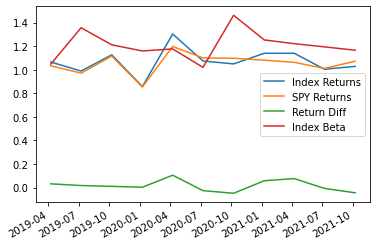

In [36]:
method1_performance = pd.DataFrame.from_dict(master_cluster_performance, orient="index")
method1_performance.plot()

In [37]:
method2_index = pd.DataFrame.from_dict(master_mean_var_index, orient="index")
method2_index

weight
2019-04-08 CVS    4.080747e-08
           EXC    1.890515e-01
           GM     4.480515e-02
           GOOGL  7.818651e-07
           HON    5.704337e-01
...                        ...
2021-10-08 JNJ    9.572088e-08
           MDLZ   6.412729e-08
           MET    2.985305e-01
           RTX    4.450003e-04
           SO     2.047240e-04

[110 rows x 1 columns]

<AxesSubplot:>

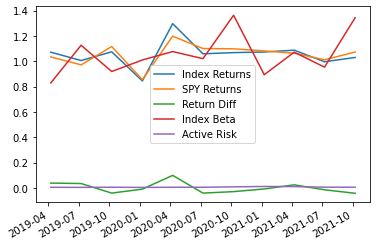

In [38]:
method2_performance = pd.DataFrame.from_dict(master_mean_var_performance, orient="index")
method2_performance.plot()

In [39]:
comp_index = method1_index.join(
    method2_index, 
    lsuffix=" method 1", 
    rsuffix=" method 2"
)
comp_index

weight method 1  weight method 2
2019-04-08 CVS           0.036136     4.080747e-08
           EXC           0.058442     1.890515e-01
           GM            0.012060     4.480515e-02
           GOOGL         0.142630     7.818651e-07
           HON           0.159778     5.704337e-01
...                           ...              ...
2021-10-08 JNJ           0.068476     9.572088e-08
           MDLZ          0.043977     6.412729e-08
           MET           0.166555     2.985305e-01
           RTX           0.064563     4.450003e-04
           SO            0.012110     2.047240e-04

[110 rows x 2 columns]

In [44]:
comp_performance = method1_performance.join(
    method2_performance, 
    lsuffix=" Method 1", 
    rsuffix=" Method 2"
).fillna(method="ffill")
comp_performance

,Index Returns Method 1,SPY Returns Method 1,Return Diff Method 1,Index Beta Method 1,Index Returns Method 2,SPY Returns Method 2,Return Diff Method 2,Index Beta Method 2,Active Risk
2019-04-08,1.065623,1.033592,0.032031,1.047939,1.071232,1.033592,0.037640,0.828577,0.004300
2019-07-08,0.989040,0.971194,0.017846,1.356476,1.005266,0.971194,0.034073,1.126033,0.003832
2019-10-08,1.126750,1.115850,0.010900,1.211554,1.074323,1.115850,-0.041527,0.918689,0.004868
2020-01-08,0.857495,0.854093,0.003402,1.159384,0.843999,0.854093,-0.010094,1.009688,0.003474
2020-04-08,1.303235,1.197795,0.105440,1.176671,1.296438,1.197795,0.098643,1.076145,0.004779
2020-07-08,1.074566,1.099994,-0.025428,1.020412,1.058448,1.099994,-0.041546,1.020084,0.004637
2020-10-08,1.049557,1.097677,-0.048120,1.462320,1.067849,1.097677,-0.029828,1.362755,0.007978
2021-01-08,1.139744,1.081134,0.058609,1.253020,1.072514,1.081134,-0.008620,0.893436,0.010868
2021-04-08,1.140051,1.063307,0.076745,1.221263,1.087174,1.063307,0.023868,1.071312,0.009980
2021-07-08,1.004320,1.011055,-0.006734,1.194233,0.995648,1.011055,-0.015407,0.953043,0.005241


In [45]:
comp_performance[
    ["Return Diff Method 1", "Return Diff Method 2"]
].add(1).cumprod().fillna(method="ffill")

,Return Diff Method 1,Return Diff Method 2
2019-04-08,1.032031,1.037640
2019-07-08,1.050449,1.072995
2019-10-08,1.061899,1.028437
2020-01-08,1.065511,1.018056
2020-04-08,1.177859,1.118480
2020-07-08,1.147908,1.072012
2020-10-08,1.092671,1.040036
2021-01-08,1.156711,1.031071
2021-04-08,1.245483,1.055681
2021-07-08,1.237096,1.039416


<AxesSubplot:>

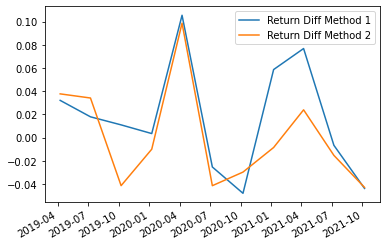

In [46]:
comp_performance.plot(y=["Return Diff Method 1", "Return Diff Method 2"])

<AxesSubplot:>

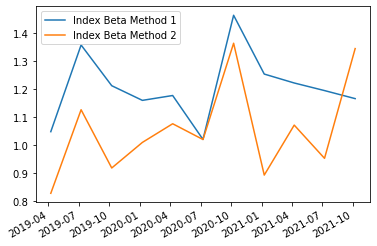

In [47]:
comp_performance.plot(y=["Index Beta Method 1", "Index Beta Method 2"])